In [2]:
%load_ext autoreload
%autoreload 2
from utils.KMeans import *
from openml.datasets import list_datasets, get_datasets
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.datasets import make_blobs
import gc
from utils.helpers import load_datasets, clean_dataset
from matplotlib import rc
import matplotlib.pylab as plt
import matplotlib 
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Computer Modern']

# Set Latex font
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)


In [3]:
%load_ext autoreload
%autoreload 2
from utils.helpers import extend_df, extend_array, generate_clusters, timeseries_plot, load_datasets, generate_complex_datasets, estimate_optimal_centroids, load_downloaded_datasets, agg_and_plot, fit_linear_regression, find_bad_initalization, addScatterPlot
from utils.KMeans import KMeans, getLables, getCentroids, getAvgDist, KMeans_sketching
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.cluster import KMeans as KMeans_sk
import pickle
from time import process_time_ns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Plot (ratio,k)

Text(0.5, 1.0, 'Evolution ratio between Assignment and Update time of executions')

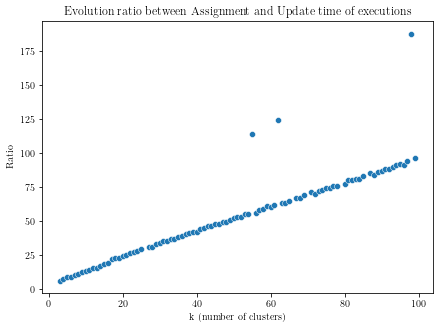

In [2]:
# Import dataset    
df = pd.read_csv('./data/measurements_1_1.csv')
# Compute ratio
df['ratio_AB_median'] = df['t_A_median']/df['t_B_median']
# Clean dataset
df_clean = clean_dataset(df)

# Plot

# Scatterplot
fig, ax = plt.subplots(figsize = (7,5))
sns.scatterplot(data=df_clean, x='n_clusters', y='ratio_AB_median', ax = ax)
ax.set_xlabel('k (number of clusters)')
ax.set_ylabel('Ratio')
ax.set_title('Evolution ratio between Assignment and Update time of executions')

# 2. Plot speculation vs basic kmeans

In [8]:
# load datasets
query = "NumberOfInstances > 10000 &\
         NumberOfInstances < 100000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list, meta = load_datasets(query, n_datasets = 10, search = True, return_meta=True)

## 2.1 Run without trace

In [6]:
# Set parameter
seed = 0
np.random.seed(seed)
k = 8
num_iter = 50
subsample_size = 0.01
tol = 0

# Create dataset
dataset_index = 0
X = X_list[dataset_index]
n, d = X.shape

# Set output path
path = './data/report/vanilla_speculation_comparison.csv'

# Compute optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Compute initial centroids
np.random.seed(seed)
initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)

# Speculation execution
labels, centroids = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, save=True, path=path, measure=True, choose_best=True, resampling=True, trace=False, tol=tol, resample_centroid=False, centroids=initial_centroids)

# Read .csv
df = pd.read_csv(path)

# Extend df to have num_iter rows
df = extend_df(df, num_iter)

# Define inertia_speculation
df['inertia_speculation'] = df[['L_slow', 'L_fast']].min(axis=1)

# Estimate optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Add L_opt
df['inertia_optimal'] = getAvgDist(X, opt_centroids)

# Add basic execution
_, _, inertia_basic = KMeans(X, k, num_iter=num_iter, seed=seed, tol=tol, centroids=initial_centroids, measure_inertia=True)
df['inertia_vanilla'] = extend_array(inertia_basic, num_iter)

df.to_csv(path, index=False)

https://www.openml.org/d/23395
The dataset used is an ARFF dataset called COMET_MC_SAMPLE, version 2, uploaded on April 22nd, 2016. It is publicly available and can be downloaded from the URL provided. It contains 6 features and 89640 instances, and can be found on OpenML with the ID 23395.

In [80]:
path = './data/report/vanilla_speculation_comparison.csv'

# import df
df = pd.read_csv(path)

# Timeseries plot
fig, ax = plt.subplots()
timeseries_plot(df[['inertia_speculation', 'inertia_optimal', 'inertia_vanilla']], xlabel='Stage', ylabel='Inertia (Average squared distance)', title = 'Vanilla K-Means, Speculation K-Means comparison', ax = ax, show = False)
addScatterPlot(ax, df['L_slow'], 'red', 'inertia_slow_execution', size = 5)
addScatterPlot(ax, df['L_fast'], 'black', 'inertia_fast_execution', size = 5)
plt.show()
meta[dataset_index]

FileNotFoundError: [Errno 2] No such file or directory: './data/report/vanilla_speculation_comparison.csv'

## 2.2 Run with trace

In [37]:
path = './data/report/vanilla_speculation_comparison_trace.csv'

In [38]:
df.to_csv(path, index=False)

In [32]:
# Set parameter
seed = 0
np.random.seed(seed)
k = 8
num_iter = 50
subsample_size = 0.01
tol = 0

# Create dataset
dataset_index = 0
X = X_list[dataset_index]
n, d = X.shape

# Set output path
path = './data/sketching/plot_2.csv'

# Compute optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Compute initial centroids
np.random.seed(seed)
initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)

# Speculation execution
labels, centroids = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, save=True, path=path, measure=True, choose_best=True, resampling=True, trace=True, tol=tol, resample_centroid=False, centroids=initial_centroids, p = 0.5, q = 0.5)

# Read .csv
df = pd.read_csv(path)

# Extend df to have num_iter rows
df = extend_df(df, num_iter)

# Define inertia_speculation
df['inertia_speculation'] = df[['L_slow', 'L_fast']].min(axis=1)

# Estimate optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Add L_opt
df['inertia_optimal'] = getAvgDist(X, opt_centroids)

# Add basic execution
_, _, inertia_basic = KMeans(X, k, num_iter=num_iter, seed=seed, tol=tol, centroids=initial_centroids, measure_inertia=True)
df['inertia_vanilla'] = extend_array(inertia_basic, num_iter)

df.to_csv(path, index=False)

https://www.openml.org/d/23395
The dataset used is an ARFF dataset called COMET_MC_SAMPLE, version 2, uploaded on April 22nd, 2016. It is publicly available and can be downloaded from the URL provided. It contains 6 features and 89640 instances, and can be found on OpenML with the ID 23395.

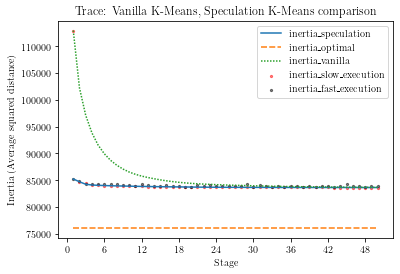

NameError: name 'meta' is not defined

In [79]:
path = './data/report/vanilla_speculation_comparison_trace.csv'

# import df
df = pd.read_csv(path)

# Timeseries plot
fig, ax = plt.subplots()
timeseries_plot(df[['inertia_speculation', 'inertia_optimal', 'inertia_vanilla']], xlabel='Stage', ylabel='Inertia (Average squared distance)', title = 'Trace: Vanilla K-Means, Speculation K-Means comparison', ax = ax, show = False)
addScatterPlot(ax, df['L_slow'], 'red', 'inertia_slow_execution', size = 5)
addScatterPlot(ax, df['L_fast'], 'black', 'inertia_fast_execution', size = 5)
plt.show()
meta[dataset_index]

## 2.3 Resampling centroids 

In [45]:
path = './data/report/vanilla_speculation_comparison_resampling.csv'

In [41]:
# Set parameter
seed = 0
np.random.seed(seed)
k = 8
num_iter = 50
subsample_size = 0.01
tol = 0

# Create dataset
dataset_index = 0
X = X_list[dataset_index]
n, d = X.shape

# Set output path
path = './data/sketching/plot_2.csv'

# Compute optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Compute initial centroids
np.random.seed(seed)
initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)

# Speculation execution
labels, centroids = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, save=True, path=path, measure=True, choose_best=True, resampling=True, trace=False, tol=tol, resample_centroid=True, centroids=initial_centroids, p = 0.8, q = 0.5)

# Read .csv
df = pd.read_csv(path)

# Extend df to have num_iter rows
df = extend_df(df, num_iter)

# Define inertia_speculation
df['inertia_speculation'] = df[['L_slow', 'L_fast']].min(axis=1)

# Estimate optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Add L_opt
df['inertia_optimal'] = getAvgDist(X, opt_centroids)

# Add basic execution
_, _, inertia_basic = KMeans(X, k, num_iter=num_iter, seed=seed, tol=tol, centroids=initial_centroids, measure_inertia=True)
df['inertia_vanilla'] = extend_array(inertia_basic, num_iter)

df.to_csv(path, index=False)

https://www.openml.org/d/23395
The dataset used is an ARFF dataset called COMET_MC_SAMPLE, version 2, uploaded on April 22nd, 2016. It is publicly available and can be downloaded from the URL provided. It contains 6 features and 89640 instances, and can be found on OpenML with the ID 23395.

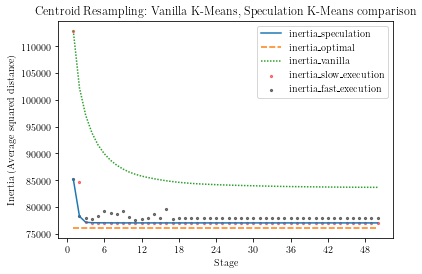

NameError: name 'meta' is not defined

In [78]:

path = './data/report/vanilla_speculation_comparison_resampling.csv'

# import df
df = pd.read_csv(path)

# Timeseries plot
fig, ax = plt.subplots()
timeseries_plot(df[['inertia_speculation', 'inertia_optimal', 'inertia_vanilla']], xlabel='Stage', ylabel='Inertia (Average squared distance)', title = 'Centroid Resampling: Vanilla K-Means, Speculation K-Means comparison', ax = ax, show = False)
addScatterPlot(ax, df['L_slow'], 'red', 'inertia_slow_execution', size = 5)
addScatterPlot(ax, df['L_fast'], 'black', 'inertia_fast_execution', size = 5)
plt.show()
meta[dataset_index]

# 3. Histogram reduced number of steps

❗Query different from before!

In [3]:
# load datasets
query = "NumberOfInstances > 500000 &\
         NumberOfInstances < 10000000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list, meta = load_datasets(query, n_datasets = 10, search = True, return_meta=True)

In [ ]:
# Set seed
seed = 0
subsample_size = 0.01
run = True
num_iter = 50
tol = 1e-3
measurements = []

# Real datasets
for i, X in enumerate(X_list):
    # Set parameters
    n, d = X.shape
    print(f'\nDataset {i}°:', end ="")
    for j, k in enumerate(range(3,11)):
        print(f' {k}', end = "")
        
        # Compute initial centroids
        np.random.seed(seed)
        initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)
              
        path = f'./data/report/histogram_steps_vanilla_id_{i}_k_{k}.csv'

        # Vanilla K-Means
        _, centroids_vanilla, steps_vanilla = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, save=True, path=path, measure=True, choose_best=False, tol=tol, centroids=initial_centroids, return_steps = True)
        inertia_vanilla = getAvgDist(X, centroids_vanilla)

        path = f'./data/report/histogram_steps_speculative_id_{i}_k_{k}.csv'
        # Speculative K-Means
        _, centroids_speculation, steps_speculation = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, return_steps = True, save=True, path=path, measure=True, choose_best=True, resampling=True, trace=True, tol=tol, resample_centroid=False, centroids=initial_centroids, p = 0.5, q = 0.5)
        inertia_speculation = getAvgDist(X, centroids_speculation)

        measurements.append({'n':n, 'd':d, 'k': k, 'i': i,'steps_vanilla':steps_vanilla, 'steps_speculation':steps_speculation, 'subsample_size':subsample_size, 'seed':seed, 'inertia_vanilla':inertia_vanilla, 'inertia_speculation':inertia_speculation})
        
# Save measurements to CSV file and compute ratio of steps for Speculative K-Means and Vanilla K-Means
df = pd.DataFrame(measurements)
df.to_csv('./data/report/histogram_steps.csv', index=False)

Text(0.5, 1.0, 'Histogram of ratio between speculation and vanilla K-Means of \\#stages and inertia')

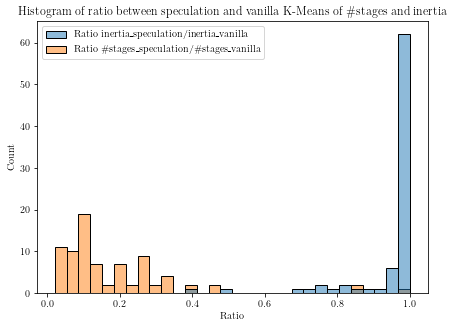

In [5]:
df = pd.read_csv('./data/report/histogram_steps.csv')
df['Ratio \#stages_speculation/\#stages_vanilla'] = df['steps_speculation'] / df['steps_vanilla']
df['Ratio inertia_speculation/inertia_vanilla'] = df['inertia_speculation'] / df['inertia_vanilla']

fig, ax = plt.subplots(figsize = (7,5))
sns.histplot(data=df[['Ratio inertia_speculation/inertia_vanilla', 'Ratio \#stages_speculation/\#stages_vanilla']], bins=30)
ax.set_xlabel('Ratio')
ax.set_ylabel('Count')
ax.set_title("Histogram of ratio between speculation and vanilla K-Means of \#stages and inertia")

# 4. Histogram escape local minima

In [81]:
# load datasets
query = "NumberOfInstances > 500000 &\
         NumberOfInstances < 10000000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list, meta = load_datasets(query, n_datasets = 10, search = True, return_meta=True)

In [8]:
# Set seed
seed = 0
subsample_size = 0.01
run = True
num_iter = 50
tol = 1e-3
measurements = []

# Real datasets
for i, X in enumerate(X_list):
    # Set parameters
    n, d = X.shape
    print(f'\nDataset {i}°:', end ="")
    for j, k in enumerate(range(3,11)):
        print(f' {k}', end = "")
        
        # Compute initial centroids
        np.random.seed(seed)
        initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)
              
        # Vanilla K-Means
        _, centroids_vanilla, steps_vanilla = KMeans(X, k, num_iter = num_iter, seed = seed, kmeans_pp = False, tol = tol, centroids = initial_centroids, return_steps = True)
        inertia_vanilla = getAvgDist(X, centroids_vanilla)
        
        # K-Means++
        _, centroids_pp, steps_pp = KMeans(X, k, num_iter = num_iter, seed = seed, kmeans_pp = True, tol = tol, return_steps = True)
        inertia_pp = getAvgDist(X, centroids_pp)
        
        # Speculative K-Means
        _, centroids_speculation, steps_speculation = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, choose_best=True, resampling=True, trace=False, tol=tol, resample_centroid=True, return_steps = True, centroids=initial_centroids, p = 0.5, q = 0.5)
        inertia_speculation = getAvgDist(X, centroids_speculation)
        
        # Estimate optimal inertia
        opt_centroids = estimate_optimal_centroids(X, k, seed=seed, n_init=50, tol=1e-6)
        inertia_optimal = getAvgDist(X, opt_centroids)
        
        measurements.append({'n':n, 'd':d, 'k': k, 'i': i, 'steps_vanilla':steps_vanilla, 'steps_speculation':steps_speculation, 'steps_pp': steps_pp, 'subsample_size':subsample_size, 'seed':seed, 'inertia_vanilla':inertia_vanilla, 'inertia_pp':inertia_pp, 'inertia_speculation':inertia_speculation, 'inertia_optimal':inertia_optimal})
        
# Save measurements to CSV file and compute ratio of steps for Speculative K-Means and Vanilla K-Means
df = pd.DataFrame(measurements)
df.to_csv('./data/report/histogram_escape_local_minima.csv', index=False)
df['ratio_vanilla'] = df['inertia_vanilla'] / df['inertia_optimal']
df['ratio_pp'] = df['inertia_pp'] / df['inertia_optimal']
df['ratio_speculation'] = df['inertia_speculation'] / df['inertia_optimal']
sns.histplot(data=df[['ratio_vanilla', 'ratio_pp', 'ratio_speculation']], bins=30)


Dataset 0°: 3 4

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

# 5. Overall time execution

In [ ]:
# load datasets
query = "NumberOfInstances > 500000 &\
         NumberOfInstances < 10000000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list, meta = load_datasets(query, n_datasets = 10, search = True, return_meta=True)

In [21]:
# Set seed
seed = 0
subsample_size = 0.01
run = True
num_iter = 50
tol = 1e-3
measurements = []

# Real datasets
for i, X in enumerate(X_list):
    # Set parameters
    n, d = X.shape
    print(f'\nDataset {i}°:', end ="")
    for j, k in enumerate(range(3,11)):
        print(f' {k}', end = "")
        
        # Compute initial centroids
        np.random.seed(seed)
        initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)
              
        # Vanilla K-Means
        _, centroids_vanilla, t_A_array, t_B_array, steps_vanilla = KMeans(X, k, num_iter = num_iter, seed = seed, kmeans_pp = False, tol = tol, centroids = initial_centroids, measure = True, return_steps = True)
        time_execution_vanilla = t_A_array.sum() + t_B_array.sum()
        inertia_vanilla = getAvgDist(X, centroids_vanilla)
        
        # Speculative K-Means
        path = f'./data/report/histogram_time_execution_id_{i}_k_{k}.csv'
        _, centroids_speculation, steps_speculation = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size=subsample_size, save=True, path=path, measure=True, choose_best=True, resampling=True, trace=True, tol=tol, resample_centroid=False, measure_time = True,centroids=initial_centroids, p = 0.5, q = 0.5, return_steps = True)
        df_speculation = pd.read_csv(path)
        time_execution_speculation = df_speculation[['t_A', 't_B','t_sampling','t_choose_best','t_get_avg','t_permutation']].to_numpy().sum()
        inertia_speculation = getAvgDist(X, centroids_speculation)
        
        measurements.append({'n':n, 'd':d, 'k': k, 'i': i, 'time_execution_vanilla':time_execution_vanilla, 'time_execution_speculation':time_execution_speculation, 'subsample_size':subsample_size, 'seed':seed, 'steps_vanilla':steps_vanilla, 'steps_speculation':steps_speculation, 'inertia_vanilla':inertia_vanilla, 'inertia_speculation':inertia_speculation})
        
# Save measurements to CSV file and compute ratio of steps for Speculative K-Means and Vanilla K-Means
df = pd.DataFrame(measurements)
df.to_csv('./data/report/histogram_time_execution.csv', index=False)
df['ratio_time'] = df['time_execution_speculation'] / df['time_execution_vanilla']
df['ratio_steps'] = df['steps_speculation'] / df['steps_vanilla']
sns.histplot(data=df['ratio_time'], bins=30)


Dataset 0°: 3 4 5

KeyboardInterrupt: 

In [22]:
measurements

[{'n': 7619400,
  'd': 5,
  'k': 3,
  'i': 0,
  'time_execution_vanilla': 3437.5,
  'time_execution_speculation': 5828.125,
  'subsample_size': 0.01,
  'seed': 0,
  'steps_vanilla': 3,
  'steps_speculation': 1,
  'inertia_vanilla': 688748.8632385718,
  'inertia_speculation': 482910.51243060624},
 {'n': 7619400,
  'd': 5,
  'k': 4,
  'i': 0,
  'time_execution_vanilla': 10843.75,
  'time_execution_speculation': 6546.875,
  'subsample_size': 0.01,
  'seed': 0,
  'steps_vanilla': 10,
  'steps_speculation': 1,
  'inertia_vanilla': 464327.2180814811,
  'inertia_speculation': 463860.79690286884}]

# Check

In [72]:
df[df.ratio >= 1]

,n,d,k,i,steps_vanilla,steps_speculation,subsample_size,seed,ratio
14,104820,7,9,1,5,7,0.01,0,1.4
15,104820,7,10,1,5,7,0.01,0,1.4
24,111753,9,3,3,1,1,0.01,0,1.0
25,111753,9,4,3,1,1,0.01,0,1.0
26,111753,9,5,3,1,1,0.01,0,1.0
27,111753,9,6,3,1,2,0.01,0,2.0
28,111753,9,7,3,1,2,0.01,0,2.0
29,111753,9,8,3,2,3,0.01,0,1.5
30,111753,9,9,3,2,3,0.01,0,1.5


In [70]:
k=6
i=3

X = X_list[i]
n, d = X.shape

# import df
df_vanilla = pd.read_csv(f'./data/report/histogram_steps_vanilla_id_{i}_k_{k}.csv')
# Extend df to have num_iter rows
df_vanilla = extend_df(df_vanilla, num_iter)
# import df
df_speculation = pd.read_csv(f'./data/report/histogram_steps_speculative_id_{i}_k_{k}.csv')
# Extend df to have num_iter rows
df_speculation = extend_df(df_speculation, num_iter)

# create empty df
df_plot = pd.DataFrame()
# Define inertia_speculation
df_plot['inertia_speculation'] = df_speculation[['L_slow', 'L_fast']].min(axis=1)

df_plot['inertia_vanilla'] = df_vanilla['L_slow']

# Compute initial centroids
np.random.seed(seed)
initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)
              
# Estimate optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed=0, n_init=50, tol=1e-6)

# Add L_opt
df_plot['inertia_optimal'] = getAvgDist(X, opt_centroids)

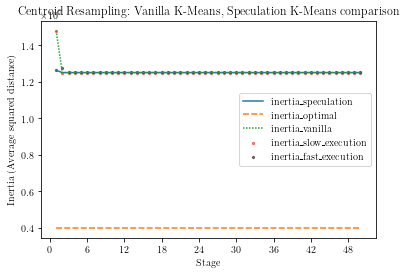

In [71]:
# Timeseries plot
fig, ax = plt.subplots()
timeseries_plot(df_plot[['inertia_speculation', 'inertia_optimal', 'inertia_vanilla']], xlabel='Stage', ylabel='Inertia (Average squared distance)', title = 'Centroid Resampling: Vanilla K-Means, Speculation K-Means comparison', ax = ax, show = False)
addScatterPlot(ax, df_speculation['L_slow'], 'red', 'inertia_slow_execution', size = 5)
addScatterPlot(ax, df_speculation['L_fast'], 'black', 'inertia_fast_execution', size = 5)
plt.show()